In [1]:
import matplotlib.pyplot as plt
import numpy as np
import phate
import random
import scipy as sp
import scprep
import sys

from sklearn.neighbors import NearestNeighbors


In [2]:
tree, branches = phate.tree.gen_dla(
    n_dim = 200, n_branch = 10, branch_length = 300, rand_multiplier = 2, seed=37, sigma = 5
)
data = tree
clusters = branches
print(tree.shape, branches.shape)

(3000, 200) (3000,)


In [3]:
phate_op = phate.PHATE()
data_ph = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 3000 observations and 200 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.38 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 1.55 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.40 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.53 seconds.
  Calculated landmark operator in 7.39 seconds.
  Calculating optimal t...
    Automatically selected t = 54
  Calculated optimal t in 4.64 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.37 seconds.
Calculated PHATE in 20.12 seconds.


/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


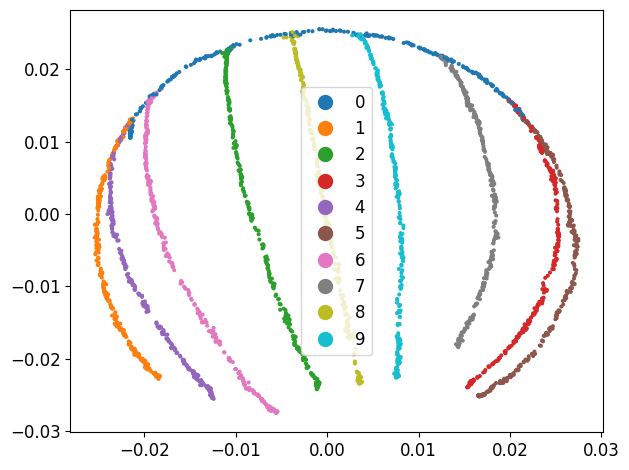

In [4]:
ax = scprep.plot.scatter2d(data_ph, c=branches)

In [83]:
bpp = BranchPointPredictor(phate_op)

In [84]:
pnm = bpp.get_pnm()
pmn = bpp.get_pmn()

In [85]:
pmn.shape, pnm.shape

((3000, 1842), (1842, 3000))

In [86]:
dmap = bpp.get_dmap()

In [87]:
dmap.shape

(1842, 1842)

In [88]:
bpp.diffuse_dirac_for_end_points()

array([243,  28])

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


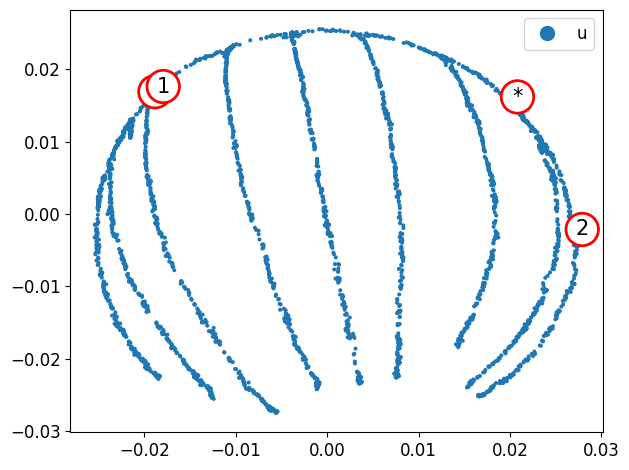

In [92]:
bpp.plot_branchs(data_ph)

In [39]:
import graphtools
phate_op.graph

In [56]:
phate_op.graph._data_transitions()

<1842x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 52262 stored elements in Compressed Sparse Row format>

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin


class BranchPointPredictor(BaseEstimator, TransformerMixin):
    def __init__(self, phate_op):
        self.phate_op = phate_op
        self.diff_op = phate_op.diff_op
        self.optimal_t = phate_op.optimal_t
        
        
        self.evals = None
        self.evecs = None
        self.dmap = None

        self.most_distinct_points = None

        self.nn_dist = None
        self.nn_idxs = None
        self.n_nbrs = None
        self.nbrs_dim_est = None
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    def get_dmap(self):
        dmap = self.dmap
        if dmap is None:
            dmap = self._calc_dmap()

        # if self.is_landmarked():
        #     dmap = self.phate_op.graph.inverse_transform(dmap)

        return dmap
    
    def _calc_dmap(self, t=None):
        if t is None:
            t = self.optimal_t

        evals, evecs = np.linalg.eig(self.diff_op)
                
        # sort eigenvectors in descending order
        idx = np.abs(evals).argsort()[::-1]
        evecs = evecs[:, idx]

        # do diffusion        
        evals = np.power(evals, self.optimal_t)
        evecs = evecs.dot(np.diag(evals))

        self.evals = evals
        self.evecs = evecs
        self.dmap = evecs        
        return evecs
    

    def get_most_distinct_points(self):
        most_distinct_points = self.most_distinct_points
        if most_distinct_points is None:
            most_distinct_points = self._calc_extrema()
        return most_distinct_points

    def _calc_extrema(self):
        return self.__calc_extrema_v2()
        return self.__calc_extrema_v1()
    
    def __calc_extrema_v1(self):
        dmap = self.get_dmap()

        # Ignore first (trivial) eigenvector
        dmap = dmap[:, 1:].copy()

        # Mask lower 50% abs val
        lower_half_abs = np.percentile(np.abs(dmap), 50)
        dmap[np.abs(dmap) < lower_half_abs] = 0

        max_idxs = dmap.argmax(axis=0)
        min_idxs = dmap.argmin(axis=0)
        extrema_idxs = np.unique(np.hstack((max_idxs, min_idxs)))
        self.most_distinct_points = extrema_idxs
        return extrema_idxs


    def __calc_extrema_v2(self):
        # Find the extremas (min and max) of the considered eigenvectors.
        # Keep them in the order of the eigenvalues by weaving min and max values.
        # min_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmin(0)
        # max_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmax(0)
        # combined_eigs = np.empty((min_eigs.size + max_eigs.size,), dtype=min_eigs.dtype)
        # combined_eigs[0::2] = min_eigs
        # combined_eigs[1::2] = max_eigs

        # Remove duplicates.

        # for e in combined_eigs:
        #     if e not in most_distinct_points:
        #         most_distinct_points.append(e)

        n_consider = self._calc_num_to_consider()
        dmap = self.get_dmap()

        most_distinct_points = []

        # Always skip the first trivial eigenvector
        for i in np.arange(n_consider):
            cur_eigvec = np.copy(dmap[:,i+1])
            # Sometimes the eigvectors are skewed towards one side (much more possitive values than negative 
            # values and vice versa). This part ensures only the extrema on the more significant side is taken.            
            lower_half_abs = np.percentile(np.abs(cur_eigvec), 50)
            cur_eigvec[np.abs(cur_eigvec) < lower_half_abs] = 0

            max_eig = np.argmax(cur_eigvec)
            min_eig = np.argmin(cur_eigvec)

            if cur_eigvec[max_eig] > 0 and max_eig not in most_distinct_points:
                most_distinct_points.append(max_eig)
            
            if cur_eigvec[min_eig] < 0 and min_eig not in most_distinct_points:
                most_distinct_points.append(min_eig)

            most_distinct_points = np.array(most_distinct_points)
        self.most_distinct_points = most_distinct_points
        return most_distinct_points    

    def _calc_num_to_consider(self):
        dmap = self.get_dmap()
        evals = self.evals
        
        # Number of eigenvectors (~ dimensions) to consider.
        dmap_diff = evals - np.roll(evals, 1)
        n_evecs = 1

        # Increase the number of eigenvectors until 
        while (dmap_diff[n_evecs + 1] > 2 * dmap_diff[n_evecs]):
            n_evecs += 1
        
        return n_evecs
    

    def is_landmarked(self):
        import graphtools
        return isinstance(self.phate_op.graph, graphtools.graphs.kNNLandmarkGraph)

    def get_pmn(self):
        # pmn = self.phate_op.graph._data_transitions()
        # original --> landmarks
        pmn = phate_op.graph.transitions
        return pmn
    
    def get_pnm(self):
        pnm = self.phate_op.graph._landmarks_to_data()
        return pnm

    def _get_full_diff_op_from_landmark_graph(self):
        pmn = self.phate_op.graph._data_transitions()
        pnm = self.phate_op.graph._landmarks_to_data()
        full_diff_op = (pnm @ self.phate_op.diff_op @ pmn)
        return full_diff_op
    
    def _knn_on_diff_op(self):
        # NOTE: using KNN on diff_map is not invertable
        # i.e. need to revert landmark graph here!
        dmap = self.get_dmap()
        #######################
        # INTRINSIC DIMENSION #
        #######################

        # Based on maxLikPointwiseDimEst() of this R package.
        # https://cran.r-project.org/web/packages/intrinsicDimension/README.html

        # Up to 100 dimensions of diffusion maps, 
        # raised to the same power as tdetermined by PHATE.
        dm_dims = min(data.shape[1], 100)
        diff_map = dmap[:,:dm_dims]
        # diff_map = diff_map.dot(np.diag(np.power(phate_op_eigvals[:dm_dims], 11)))
        if self.is_landmarked():
            diff_map = self.phate_op.graph.interpolate(diff_map)
        
        

        # Rank all neighbors in diffusion map coordinates.
        nbrs = NearestNeighbors(
            # n_neighbors=dm_dims,
            n_neighbors=diff_map.shape[0],
            algorithm='ball_tree'
        ).fit(diff_map)

        nn_distances, nn_indices = nbrs.kneighbors(diff_map)
        nn_distances = nn_distances[:, 1:]
        nn_indices = nn_indices[:, 1:]
        return nn_distances, nn_indices

    def max_likelihood_pointwise_dimensionality_est(self):
        nn_dist, nn_idxs = self._knn_on_diff_op()
        most_distinct_points = self.get_most_distinct_points()
        # Maximum Likelihood pointwise dimensionality estimation
        # Hill (1975), Levina and Bickel (2005)
        row_max = np.max(nn_dist, axis=1)
        row_max = row_max.reshape(len(row_max), 1)
        dim_est = np.sum(np.log(row_max / nn_dist), axis=1)

        # Calculate the average dim_est of local neighborhood.
        n_nbrs = min(data.shape[0] // 20, 100)
        nbrs_dim_est = np.average(dim_est[nn_idxs[:, :n_nbrs]], axis=1)
        # nbrs_dim_est = phate_op.graph.interpolate(nbrs_dim_est)

        # Calculate ranking of neighborhood dim_est, from low to high
        temp = nbrs_dim_est.argsort()
        nbrs_dim_est_ranks = np.empty_like(temp)
        nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

        # Make sure that all distinct points are end points (low dim_est), not branch point (high dim_est)
        low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < data.shape[0] // 2
        most_distinct_points = most_distinct_points[low_dim_est_mask]
        self.nn_dist = nn_dist
        self.nn_idxs = nn_idxs
        self.n_nbrs = n_nbrs
        self.nbrs_dim_est = nbrs_dim_est
        return nn_dist, nn_idxs, n_nbrs, nbrs_dim_est

    def diffuse_dirac_for_end_points(self):
        nn_dist, nn_idxs, n_nbrs, nbrs_dim_est = self.max_likelihood_pointwise_dimensionality_est()
        most_distinct_points = self.get_most_distinct_points()
        ##################################
        # DIFFUSING DIRAC FOR END POINTS #
        ##################################
        pnm = None
        pmn = None
        opt_t = self.optimal_t
        if self.is_landmarked():                                
            pnm = self.get_pnm()
            pmn = self.get_pmn()
        

        branch_points = []
        classes = np.zeros(data.shape[0], dtype="int32")
        classes_value = np.repeat(-float('inf'), data.shape[0])
        for end_point_index in np.arange(most_distinct_points.size):
            cur_end_point = most_distinct_points[end_point_index]
                        
            if self.is_landmarked():
                undo_diff = (pmn @ self.diff_op @ pnm)
                diff_op_t = np.linalg.matrix_power(undo_diff, opt_t)
            else:
                diff_op_t = np.linalg.matrix_power(self.diff_op, opt_t)            
                # diff_op_t = phate_op.graph.interpolate(diff_op_t)
                # diff_op_t = (phate_op.graph.transitions @ diff_op_t)

            branch_point_dim_est_avg_cache = -float('inf')

            for it in range(20):
                branch_from_end_point = diff_op_t[:, cur_end_point]

                branch_max = np.max(branch_from_end_point)
                branch_min = np.min(branch_from_end_point)
                
                branch_threshold = branch_min + (branch_max - branch_min) * 0.1
                
                deviation_from_branch_threshold = branch_from_end_point - branch_threshold
                deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = float('inf')

                cur_branch_point = deviation_from_branch_threshold.argmin()
                potential_branch_points = np.argpartition(deviation_from_branch_threshold, 20)[:20]
                
                branch_point_dim_est_avg = np.average(nbrs_dim_est[potential_branch_points])
                if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
                    break
                branch_point_dim_est_avg_cache = branch_point_dim_est_avg
                
                
                if self.is_landmarked():                                
                    undo_diff = (pmn @ self.diff_op @ pnm)
                    diff_op_t = diff_op_t.dot(undo_diff)
                else:
                    diff_op_t = diff_op_t.dot(phate_op.diff_op)

            branch_points.append(cur_branch_point)
            on_branch_mask = diff_op_t[:,cur_end_point] > branch_threshold
            color = diff_op_t[:, cur_end_point]

            on_branch_mask[color < classes_value] = 0
            
            color[np.logical_not(on_branch_mask)] = -np.max(color)

            classes_value[on_branch_mask] = color[on_branch_mask]
            classes[on_branch_mask] = end_point_index + 1
            self.classes = classes

        #####################
        # REMOVE DUPLICATES #
        #####################
        # We want to remove branch points that are too close together.

        branch_points = np.array(branch_points)
        branch_point_nbrs = nn_idxs[branch_points,:n_nbrs]
        branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
        center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
        neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
        branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))


        # For each pair of branch_points, keep only the one with higher eigenvalue.
        # (mdb_pairs, by construction, is sorted by decreasing eigenvalue corresponding 
        # to the first point of each pair.)
        points_to_exclude = []
        for pair in branch_point_pairs:
            if pair[0] not in points_to_exclude:
                points_to_exclude.append(pair[1])

        branch_points = np.delete(branch_points, np.argwhere(np.isin(branch_points, points_to_exclude)))
        self.branch_points = branch_points
        return branch_points
    
    def plot_branchs(self, emb, classes=None):
        most_distinct_points = self.most_distinct_points
        branch_points = self.branch_points
        # Plot by class with end points and branch points
        if classes is None:
            classes = self.classes
            classes = ['u' for e in emb]

        ax = scprep.plot.scatter2d(emb, c=classes)
        plot_numbers = np.repeat("", emb.shape[0])
        plot_numbers[most_distinct_points] = np.arange(most_distinct_points.shape[0]) + 1
        plot_numbers[branch_points] = "*"
        bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
        
        for i, txt in enumerate(plot_numbers):
            ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)


    def assign_branches(self):
        ###################
        # ASSIGN BRANCHES #
        ###################
        dmap = self.get_dmap()
        most_distinct_points = self.most_distinct_points

        # Find coordinates between every point and every MDP.
        all_dm_coords = dmap
        mdp_dm_coords = dmap[most_distinct_points,:]
        pairwise_dist = sp.spatial.distance.cdist(all_dm_coords, mdp_dm_coords)

        # For every point, rank MDPs by increasing distance.
        s = np.argsort(pairwise_dist, axis=1)
        i = np.arange(pairwise_dist.shape[0]).reshape(-1, 1)
        j = np.arange(pairwise_dist.shape[1])
        
        mdp_ranking = np.empty_like(pairwise_dist, dtype=int)
        mdp_ranking[i, s] = j + 1

        # Assign every point to the branch between its two most highly ranked MDPs.
        mdp_1 = np.argwhere(mdp_ranking==1)[:,1] + 1
        mdp_2 = np.argwhere(mdp_ranking==2)[:,1] + 1
        
        branch_classes = list(zip(mdp_1, mdp_2))
        branch_classes = [str(sorted(branch_class)) for branch_class in branch_classes]
        
        ax = scprep.plot.scatter2d(data_ph, c=branch_classes)
        
        plot_numbers = np.repeat("", data_ph.shape[0])
        plot_numbers[most_distinct_points] = np.arange(most_distinct_points.shape[0]) + 1
        bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

        # sys.stdout = open('trash', 'w')
        for i, txt in enumerate(plot_numbers):
            ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)    